## Курсовой проект для курса "Python для Data Science"


#### Материалы к проекту (файлы):
train.csv, test.csv

#### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Целевая переменная:
Price

#### Метрика качества:
R2 - коэффициент детерминации

In [1]:
#Подключение библиотек и скриптов


import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 5, 3

from scipy.stats import norm
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split

### 5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Lasso, Ridge
#from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score as r2

In [2]:
import warnings
warnings.filterwarnings('ignore')

##### Функции для дальнейшего использования

In [3]:
# отрисовка точечной диаграммы по двум признакам

def scatter(x, y, df):
    plt.scatter(df[x], df[y])    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [4]:
# замена значений А/В на числовые

def AB_to_int(columns, df):
    for column in columns:
        df[column].replace(['A', 'B'], [0, 1], inplace=True)

In [5]:
# замена выбросов на медиану для всех датасетов

def spike_fix(feature, df, min_value, max_value):
    df.loc[df[feature] <= min_value, feature] = df[feature].median()
    df.loc[df[feature] >= max_value, feature] = df[feature].median()

In [6]:
# заполнение пропусков с помощью коэф. зависимости

def isnull_fill(df, main_col, sub_col):
    index=df[main_col].mean()/df[sub_col].mean()
    df.loc[df[sub_col].isnull(), sub_col] = df[main_col]/index

In [7]:
# ликвидация ошибочных данных по количеству комнат Rooms 
## Я не боюсь дробных значений комнат, т.к. я поменяла тип Rooms на int

def rooms_fix(df, min_value, max_value):
    index=df['Square'].mean()/df['Rooms'].mean()
    df.loc[df['Rooms'] <= min_value, 'Rooms'] = df['Square']/index
    df.loc[df['Rooms'] > max_value, 'Rooms'] = df['Square']/index    

In [8]:
# замена некорректых площадей Square

def square_fix (df, sum_col, add1_col, add2_col):
    df.loc[df[sum_col] < (df[add1_col] + df[add2_col]), sum_col] = df[add1_col] + df[add2_col]

In [9]:
# обучение датасета по модели, предсказание и расчет метрики r2_score

def r2_score_result (X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train) 
    y_test_pred = model.predict(X_test)
    r2_train = r2(y_train, y_train_pred)
    r2_test = r2(y_test, y_test_pred)
    print(f'r2_train = {r2_train.round(5)}')
    print(f'r2_test = {r2_test.round(5)}')
    
    plt.scatter(y_train, y_train_pred)    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values for TRAIN')
    plt.show()
    
    plt.scatter(y_test, y_test_pred)    
    plt.xlabel('Predicted values for TEST')
    plt.ylabel('True values')
    plt.title('True vs Predicted values for TEST')
    plt.show()

## Загрузка данных

### Описание датасета:

In [10]:
#пути к файлам csv с обучающим и тестовым датасетами

TRAIN_DATASET_PATH = 'C:/Users/sklod/OneDrive/Рабочий стол/STUDY/!PRACTICUM/Q1.Pithon_lib/project_task/train.csv'
TEST_DATASET_PATH = 'C:/Users/sklod/OneDrive/Рабочий стол/STUDY/!PRACTICUM/Q1.Pithon_lib/project_task/test.csv'
TEST_DATASET_EXT_PATH = 'C:/Users/sklod/OneDrive/Рабочий стол/STUDY/!PRACTICUM/Q1.Pithon_lib/project_task/IAnikushina_predictions.csv'

In [11]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [12]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58    2.0  49.882643   33.432782            6.0      6   
1  15856          74    2.0  69.263183         NaN            1.0      6   
2   5480         190    1.0  13.597819   15.948246           12.0      2   
3  15664          47    2.0  73.046609   51.940842            9.0     22   
4  14275          27    1.0  47.527111   43.387569            1.0     17   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199         B         B        11      2748   
1         1.0       1977   0.075779         B         B         6      1437   
2         5.0       1909   0.000000         B         B        30      7538   
3        22.0       2007   0.101872         B         B        23      4583   
4        17.0       2017   0.072158         B         B         2       629   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         1           NaN            0        0       B  
1         3           NaN            0        2       B  
2        87        4702.0            5        5       B  
3         3           NaN            3        3       B  
4         1           NaN            0        0       A

In [13]:
# информация по признакам и типам в обучающем и тестовом датасете соответствует, за исключением количества значений и Price

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## Обработка данных 

### Обучающий датасет

In [14]:
# Есть несколько столбцов с некорректным типом float64 для параметров, которые могут быть только целыми числами

train_df['Rooms'] = train_df['Rooms'].astype('int64')
train_df['HouseFloor'] = train_df['HouseFloor'].astype('int64')

##### В датасетах несколько столбцов с типом object. Делаем обзор номинативных параметров

In [15]:
## Обзор номинативных параметров

df_obj_features = train_df.select_dtypes(include='object').columns
df_obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [16]:
train_df["Ecology_2"].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [17]:
train_df["Ecology_3"].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [18]:
train_df["Shops_2"].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [19]:
# Данные параметры принимают только 2 значения 
# Проводим преобразование значений 'А' и 'В' к числовому формату с помощью функции

AB_to_int(df_obj_features, train_df)

In [20]:
# Проверка: в обучающем датасете нет параметров типа object

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  int64  
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Анализ пропусков и выбросов

In [21]:
# в обучающем наборе 10000 строк, пропуски по 2м параметрам

train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [22]:
## в проверочном наборе 5000 строк, пропуски по 2м параметрам
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [23]:
train_df.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

          Ecology_2     Ecology_3      Social_1      Social_2      Social_3  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.990300      0.972500     24.687000   5352.157400      8.039200   
std        0.098015      0.163543     17.532614   4006.799803     23.831875   
min        0.000000      0.000000      0.000000    168.000000      0.000000   
25%        1.000000      1.000000      6.000000   1564.000000      0.000000   
50%        1.000000      1.000000     25.000000   5285.000000      2.000000   
75%        1.000000      1.000000     36.000000   7227.000000      5.000000   
max        1.000000      1.000000     74.000000  19083.000000    141.000000   

       Healthcare_1   Helthcare_2       Shops_1       Shops_2          Price  
count   5202.000000  10000.000000  10000.000000  10000.000000   10000.000000  
mean    1142.904460      1.319500      4.231300      0.917500  214138.857399  
std     1021.517264      1.493601      4.806341      0.275139   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%      350.000000      0.000000      1.000000      1.000000  153872.633942  
50%      900.000000      1.000000      3.000000      1.000000  192269.644879  
75%     1548.000000      2.000000      6.000000      1.000000  249135.462171  
max     4849.000000      6.000000     23.000000      1.000000  633233.466570

##### В данных есть недочеты: Rooms от 0 до 19, выбросы в Square, LifeSquare, KitchenSquare, HouseYear, также пропуски в LifeSquare и Healthcare_1. Сначала необходимо убрать выбросы, потом заполнить пропуски.

In [24]:
# предположительно площадь квартиры не может быть меньше 20 м2, а значений, превышающих 150м2 всего 26 из 10000 
## сделаю данные значения пограничными для данного параметра

train_df[train_df['Square'] >= 150].count()

Id               26
DistrictId       26
Rooms            26
Square           26
LifeSquare       19
KitchenSquare    26
Floor            26
HouseFloor       26
HouseYear        26
Ecology_1        26
Ecology_2        26
Ecology_3        26
Social_1         26
Social_2         26
Social_3         26
Healthcare_1     12
Helthcare_2      26
Shops_1          26
Shops_2          26
Price            26
dtype: int64

In [25]:
# заменяем выбросы по признаку Square на mediana с помощью функции

spike_fix('Square', train_df, 20, 150)

In [26]:
# количество комнат имеет выбросы
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

In [27]:
# общая площадь завист от количества комнат
# комнат не может быть 0, токже их врядли больше 6 (6 не исключаю)
## заполним выбросы в комнатах с помощью функции, которая высчитывает коэф зависимости между этими параметрами

rooms_fix(train_df, 0, 6)

In [28]:
# поскольку жилая площадь не может превышать общую, заменяем выбросы по признаку LifeSquare на mediana с помощью функции

spike_fix('LifeSquare', train_df, 20, 150)

In [29]:
# заполняем пробелы в LifeSquare с помощью функции, которая исследует зависимость LifeSquare от Square

isnull_fill(train_df, 'Square', 'LifeSquare')

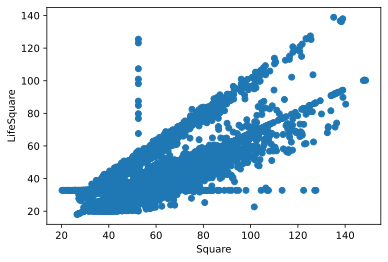

In [30]:
# посмотрим как выглядит диаграмма зависимости параметров LifeSquare от Square после всех корректировок
# cущественных выбросов нет

scatter('Square', 'LifeSquare', train_df)

In [31]:
# помним про выбросы по KitchenSquare - за минимальную возмем 5 м2, а за максимальную - 20м2
## количество больше 20м2 незначительное - 48 из 10000 - можно отбросить

train_df.loc[train_df['KitchenSquare'] >20].count()

Id               48
DistrictId       48
Rooms            48
Square           48
LifeSquare       48
KitchenSquare    48
Floor            48
HouseFloor       48
HouseYear        48
Ecology_1        48
Ecology_2        48
Ecology_3        48
Social_1         48
Social_2         48
Social_3         48
Healthcare_1     20
Helthcare_2      48
Shops_1          48
Shops_2          48
Price            48
dtype: int64

In [32]:
# заменяем выбросы по признаку KitchenSquare на mediana 

spike_fix('KitchenSquare', train_df, 5, 20)

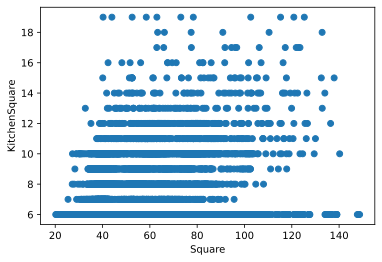

In [33]:
# исследуем зависимость KitchenSquare от Square
# существенных выбросов нет

scatter('Square', 'KitchenSquare', train_df)

In [34]:
# поскольку общая площадь не может быть меньше, чем жилая площать в сумме с кухней, я заменяю выпадающте значения

square_fix (train_df, 'Square', 'LifeSquare', 'KitchenSquare')

In [35]:
# предположим, что параметры Helthcare_2 и Healthcare_1 между собой связаны
# заполню пропуски по Healthcare_1 с помощью функции 

isnull_fill(train_df, 'Helthcare_2', 'Healthcare_1')

In [36]:
# теперь нужно устранить выбросы по годам

train_df['HouseYear'].nlargest(5)

1497    20052011
4189        4968
585         2020
707         2020
790         2020
Name: HouseYear, dtype: int64

In [37]:
test_df['HouseYear'].nlargest(5)

385     2020
888     2020
1039    2020
1275    2020
3255    2020
Name: HouseYear, dtype: int64

In [38]:
# поскольку в двух датасетах всего 2 некорректных даты (в обучающем), я заменю их вручную на наиболее вероятные

train_df.loc[1497, 'HouseYear'] = 2011
train_df.loc[4189, 'HouseYear'] = 1968

In [39]:
# еще раз изучим получившийся обучающий датасет

train_df.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    8383.40770     50.400800      1.888980     57.049149     38.482378   
std     4859.01902     43.587592      0.812739     18.070187     14.756674   
min        0.00000      0.000000      1.000000     26.553188     17.998767   
25%     4169.50000     20.000000      1.000000     42.543960     29.168016   
50%     8394.50000     36.000000      2.000000     53.090755     33.613770   
75%    12592.50000     75.000000      2.000000     66.740544     45.352896   
max    16798.00000    209.000000      6.000000    151.697187    138.910187   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean        7.437200      8.526700     12.609400   1984.866300      0.118858   
std         1.989737      5.241148      6.775974     18.412271      0.119025   
min         6.000000      1.000000      0.000000   1910.000000      0.000000   
25%         6.000000      4.000000      9.000000   1974.000000      0.017647   
50%         6.000000      7.000000     13.000000   1977.000000      0.075424   
75%         9.000000     12.000000     17.000000   2001.000000      0.195781   
max        19.000000     42.000000    117.000000   2020.000000      0.521867   

          Ecology_2     Ecology_3      Social_1      Social_2      Social_3  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.990300      0.972500     24.687000   5352.157400      8.039200   
std        0.098015      0.163543     17.532614   4006.799803     23.831875   
min        0.000000      0.000000      0.000000    168.000000      0.000000   
25%        1.000000      1.000000      6.000000   1564.000000      0.000000   
50%        1.000000      1.000000     25.000000   5285.000000      2.000000   
75%        1.000000      1.000000     36.000000   7227.000000      5.000000   
max        1.000000      1.000000     74.000000  19083.000000    141.000000   

       Healthcare_1   Helthcare_2       Shops_1       Shops_2          Price  
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000  
mean     881.326067      1.319500      4.231300      0.917500  214138.857399  
std     1057.729707      1.493601      4.806341      0.275139   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000      0.000000      1.000000      1.000000  153872.633942  
50%      645.000000      1.000000      3.000000      1.000000  192269.644879  
75%     1130.000000      2.000000      6.000000      1.000000  249135.462171  
max     4849.000000      6.000000     23.000000      1.000000  633233.466570

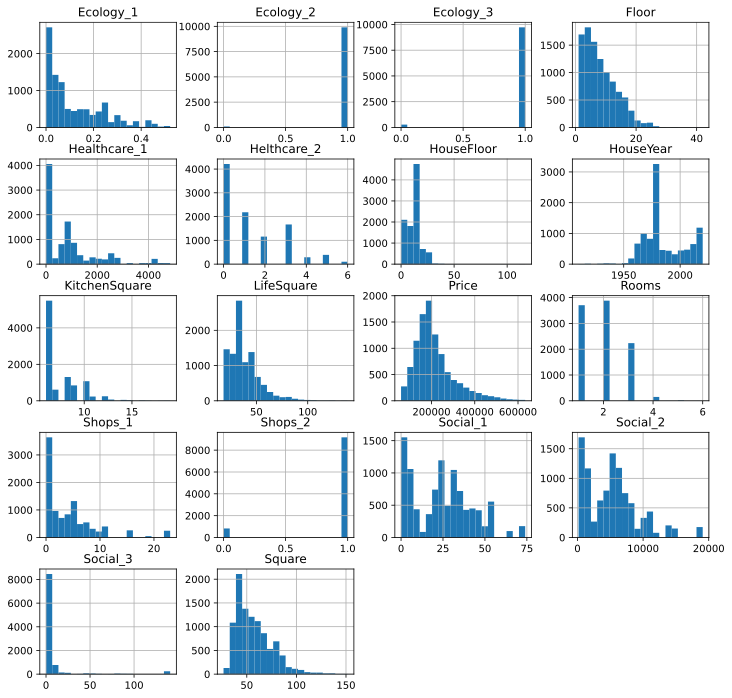

In [40]:
# еще раз наглядно убедимся, что нет никаких существенных выбросов

features = train_df.columns.drop('Id').drop('DistrictId')
train_df[features].hist(figsize=(12,12), bins=20);

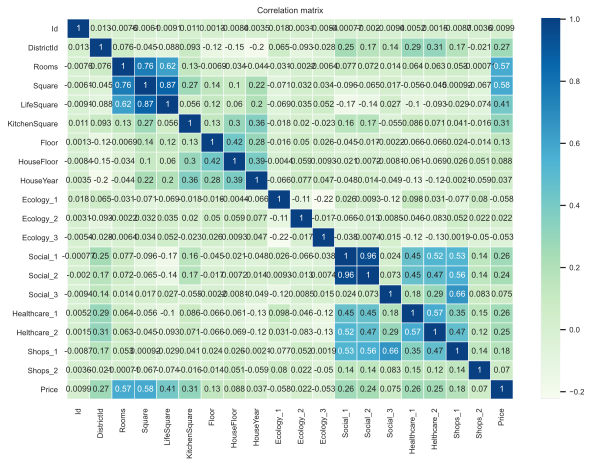

In [41]:
# изучим степень корреляции всех признаков между собой и с целевой переменной.

plt.figure(figsize = (10,7))

sns.set(font_scale=0.7)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

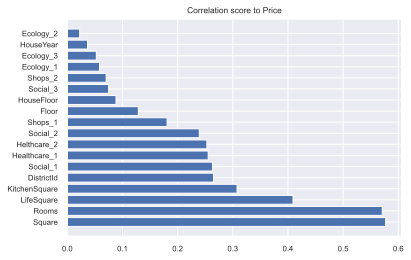

In [42]:
# степень корреляции в порядке возрастания

corr_score = train_df.loc[:, train_df.columns != 'Id'].corrwith(train_df['Price']).abs().sort_values(ascending=False)[1:]
plt.barh(corr_score.index, corr_score.values)
plt.title('Correlation score to Price')
plt.show()

### Преобразование датасета

In [43]:
# Я решила оставить все признаки, кроме ID (удаление даже самых невесомых признаков снижает показатель r2)

features = train_df.columns.drop('Id').drop('Price')
target = train_df['Price']
X = pd.DataFrame(train_df, columns=features)
y = pd.DataFrame(target, columns=['Price'])

### Разбивка обучающего датасета на тренировочный и валидационный

In [44]:
# разбиваем обучающий датасет

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

### Построение модели

In [45]:
# Сначала проведем стандартизацию признаков 

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)

X_valid_scaled = scaler.fit_transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=features)

##### Ниже привожу показатели для моделей, которые оказались менее эффективными

#### Линейная регрессия, Lasso и Ridge показали одинаковый результат
r2_train = 0.55592

r2_test = 0.53924

#### Random Forest

r2_train = 0.96102

r2_test = 0.69772

##### Самой результативной оказалась модель Gredient Boosting после подбора оптимальных параметров

In [46]:
# Gradient Boosting

gb_model = GradientBoostingRegressor()

r2_train = 0.77064
r2_test = 0.68753


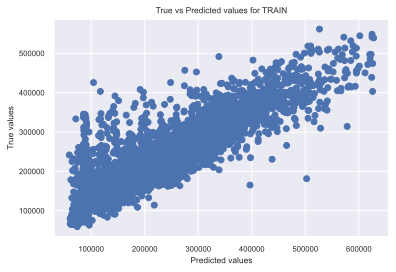

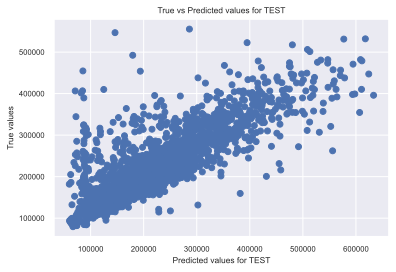

In [47]:
r2_score_result (X_train_scaled, y_train, X_valid_scaled, y_valid, gb_model)

In [48]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [49]:
print(f'gs.best_params = ', gs.best_params_, ' gs.best_score = ', gs.best_score_)

gs.best_params =  {'max_depth': 5, 'n_estimators': 200}  gs.best_score =  0.7359783713207396


In [50]:
new_gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=21)

r2_train = 0.90465
r2_test = 0.71519


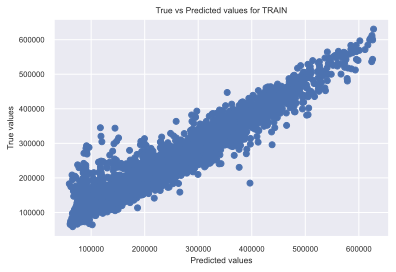

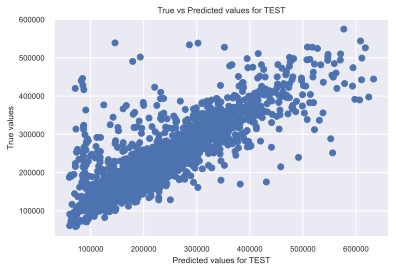

In [51]:
r2_score_result (X_train_scaled, y_train, X_valid_scaled, y_valid, new_gb)

### R2 на тестовом дата сете - 0.71519! Но может быть больше
 
#### Я специально вынесла добавление доп.параметров в отдельную исторю, чтоб можно было сравнить результаты


## Добавление дополнительных параметров в обучающий массив

In [52]:
# То, что пришло мне в голову - добавить среднюю площадь комнаты для каждой квартиры

train_df['RoomSize'] = train_df['LifeSquare'] / train_df['Rooms']

In [53]:
# А это беспощадный плагиат с разбора полётов перед курсовой. "Пять минут, полёт нормальный!"

district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

DistrictId  DistrictSize
0          27           851
1           1           652
2          23           565
3           6           511
4           9           294

In [54]:
# Вливаем добытый размер дистрикта в обучающий датасет по признаку DistrictId

train_df = train_df.merge(district_size, on='DistrictId', how='left')

In [55]:
# Продолжаем плагиатить и добавляем еще один параметр - признак величины дистрикта

train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [56]:
# Это плагиат, который я видоизменила, чтоб было не так стыдно
# Самым очевидным признаком мне показалась цена за м2

train_df['PriceSQM'] = train_df['Price'] / train_df['Square']

In [57]:
# И с помощью разбора полетов я смогла высчитать среднюю стоимость за м2 по дистриктам

med_distr_price_sqm = train_df.groupby(['DistrictId'], as_index=False).agg({'PriceSQM':'median'})\
                       .rename(columns={'PriceSQM':'MedDistrPriceSQM'})

med_distr_price_sqm

DistrictId  MedDistrPriceSQM
0             0       3641.877445
1             1       3124.742375
2             2       4480.276237
3             3       3721.291478
4             4       5439.399402
..          ...               ...
200         202       7447.527733
201         205       5101.016598
202         207       5550.678339
203         208       8005.605047
204         209       3611.249392

[205 rows x 2 columns]

In [58]:
# Вливаем добытую среднюю по дистрикту стоимость за м2 в обучающий датасет по признаку DistrictId

train_df = train_df.merge(med_distr_price_sqm, on=['DistrictId'], how='left')

# и посмотрим, во что превраитился датасет

train_df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            6.0      8   
3   5809          58    2.0  61.731512   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1  ...  Healthcare_1  Helthcare_2  Shops_1  \
0           9       1969   0.089040  ...           0.0            0       11   
1           9       1978   0.000070  ...         240.0            1       16   
2          12       1968   0.049637  ...         229.0            1        3   
3          17       1977   0.437885  ...        1084.0            0        5   
4          12       1976   0.012339  ...        2078.0            2        4   

   Shops_2          Price   RoomSize  DistrictSize  IsDistrictLarge  \
0        1  184966.930730  14.721375            22                0   
1        1  300009.450063  13.349848            87                0   
2        1  220925.908524  14.598806           174                1   
3        1  175616.227217  26.365756           179                1   
4        1  150226.531644  23.776169            97                0   

      PriceSQM  MedDistrPriceSQM  
0  3854.958571       4358.274853  
1  4567.491245       4395.277115  
2  4915.149522       4793.999317  
3  2844.839230       2878.238727  
4  3788.892642       3956.881985  

[5 rows x 25 columns]

In [59]:
# делаем разбивку обновленного обучающего датасета на тренировочный и валидный 
# убираю признак PriceSQM потому что он, как оказалось, вызывает переобучение модели

features = train_df.columns.drop('Id').drop('Price').drop('PriceSQM')
target = train_df['Price']
X = pd.DataFrame(train_df, columns=features)
y = pd.DataFrame(target, columns=['Price'])

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
# Снова стандартизация

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)

X_valid_scaled = scaler.fit_transform(X_valid)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=features)

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DistrictId        7000 non-null   int64  
 1   Rooms             7000 non-null   float64
 2   Square            7000 non-null   float64
 3   LifeSquare        7000 non-null   float64
 4   KitchenSquare     7000 non-null   float64
 5   Floor             7000 non-null   int64  
 6   HouseFloor        7000 non-null   int64  
 7   HouseYear         7000 non-null   int64  
 8   Ecology_1         7000 non-null   float64
 9   Ecology_2         7000 non-null   int64  
 10  Ecology_3         7000 non-null   int64  
 11  Social_1          7000 non-null   int64  
 12  Social_2          7000 non-null   int64  
 13  Social_3          7000 non-null   int64  
 14  Healthcare_1      7000 non-null   float64
 15  Helthcare_2       7000 non-null   int64  
 16  Shops_1           7000 non-null   int64

r2_train = 0.80007
r2_test = 0.71982


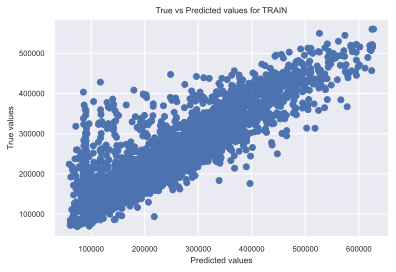

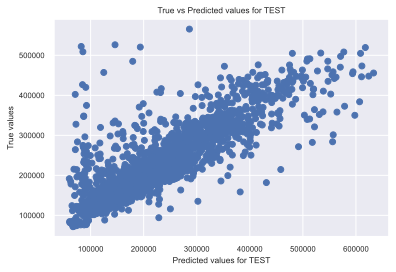

In [63]:
# модель Gradient Boosting оказалась самой результативной - продлжаю работать с ней

r2_score_result (X_train_scaled, y_train, X_valid_scaled, y_valid, gb_model)

In [64]:
# теперь подберем лучшие параметры для модели

params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [65]:
print(f'gs.best_params = ', gs.best_params_, ' gs.best_score = ', gs.best_score_)

gs.best_params =  {'max_depth': 5, 'n_estimators': 100}  gs.best_score =  0.7457435849824741


In [66]:
new_gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=21)

r2_train = 0.87483
r2_test = 0.73517


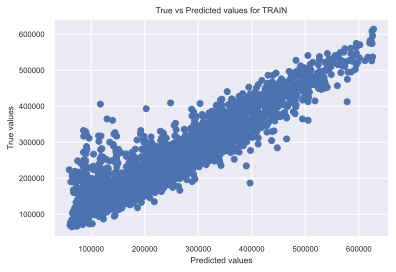

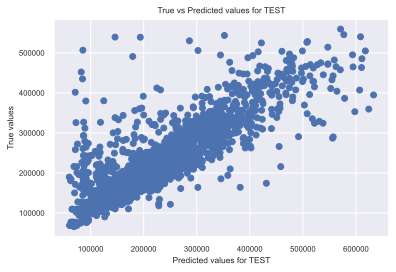

In [67]:
r2_score_result (X_train_scaled, y_train, X_valid_scaled, y_valid, new_gb)

## R2 на модели Gradient Boosting после внесения доп параметров - 0.73517 (test)!

In [68]:
# Важность признаков (попытка откинуть самые незначительные не дала положительного результата)

feature_importances = pd.DataFrame(zip(X_train_scaled.columns, new_gb.feature_importances_), 
                                    columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
2             Square    0.431504
21  MedDistrPriceSQM    0.394033
1              Rooms    0.028511
7          HouseYear    0.023855
12          Social_2    0.014216
18          RoomSize    0.013138
5              Floor    0.013037
6         HouseFloor    0.012958
4      KitchenSquare    0.010651
8          Ecology_1    0.010483
11          Social_1    0.008423
0         DistrictId    0.007751
3         LifeSquare    0.007109
14      Healthcare_1    0.006507
13          Social_3    0.006388
19      DistrictSize    0.004465
16           Shops_1    0.003611
15       Helthcare_2    0.002098
10         Ecology_3    0.000584
9          Ecology_2    0.000380
17           Shops_2    0.000296
20   IsDistrictLarge    0.000002

##### Строим модель на изначальном обучающем датасете, чтоб она была более полноценна для применения на тестовом датасете

In [69]:
# Стандартизация обучающего датасета X 

X_full_scaled = scaler.fit_transform(X)
X_full_scaled = pd.DataFrame(X_full_scaled, columns=features)

In [70]:
# используем наиболее успешную модель для обучения

new_gb.fit(X_full_scaled, y)
y_full_pred = new_gb.predict(X_full_scaled) 

r2_full = r2(y, y_full_pred)

print(f'r2_full = {r2_full.round(5)}')

r2_full = 0.85615


## Предсказание на тестовом датасете

### Обработка данных для тестового датасета

In [71]:
## целочисельный тип параметов
test_df['Rooms'] = test_df['Rooms'].astype('int64')
test_df['HouseFloor'] = test_df['HouseFloor'].astype('int64')

## обработка номинативных параметров
AB_to_int(df_obj_features, test_df)

## обработка пропусков и выбросов
spike_fix('Square', test_df, 20, 150)
rooms_fix(test_df, 0, 6)
spike_fix('LifeSquare', test_df, 20, 150)
isnull_fill(test_df, 'Square', 'LifeSquare')
spike_fix('KitchenSquare', test_df, 5, 20)
square_fix (test_df, 'Square', 'LifeSquare', 'KitchenSquare')
isnull_fill(test_df, 'Helthcare_2', 'Healthcare_1')

In [72]:
# заведение доп.параметров

test_df['RoomSize'] = test_df['LifeSquare'] / test_df['Rooms']
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)
test_df = test_df.merge(med_distr_price_sqm, on=['DistrictId'], how='left')

In [73]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                5000 non-null   int64  
 1   DistrictId        5000 non-null   int64  
 2   Rooms             5000 non-null   float64
 3   Square            5000 non-null   float64
 4   LifeSquare        5000 non-null   float64
 5   KitchenSquare     5000 non-null   float64
 6   Floor             5000 non-null   int64  
 7   HouseFloor        5000 non-null   int64  
 8   HouseYear         5000 non-null   int64  
 9   Ecology_1         5000 non-null   float64
 10  Ecology_2         5000 non-null   int64  
 11  Ecology_3         5000 non-null   int64  
 12  Social_1          5000 non-null   int64  
 13  Social_2          5000 non-null   int64  
 14  Social_3          5000 non-null   int64  
 15  Healthcare_1      5000 non-null   float64
 16  Helthcare_2       5000 non-null   int64  


In [74]:
# Пропуски по признакам DistrictSize и MedDistrPriceSQM заполним средним значением

test_df.loc[test_df['DistrictSize'].isnull(), 'DistrictSize'] = test_df['DistrictSize'].mean()
test_df.loc[test_df['MedDistrPriceSQM'].isnull(), 'MedDistrPriceSQM'] = test_df['MedDistrPriceSQM'].mean()

In [75]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                5000 non-null   int64  
 1   DistrictId        5000 non-null   int64  
 2   Rooms             5000 non-null   float64
 3   Square            5000 non-null   float64
 4   LifeSquare        5000 non-null   float64
 5   KitchenSquare     5000 non-null   float64
 6   Floor             5000 non-null   int64  
 7   HouseFloor        5000 non-null   int64  
 8   HouseYear         5000 non-null   int64  
 9   Ecology_1         5000 non-null   float64
 10  Ecology_2         5000 non-null   int64  
 11  Ecology_3         5000 non-null   int64  
 12  Social_1          5000 non-null   int64  
 13  Social_2          5000 non-null   int64  
 14  Social_3          5000 non-null   int64  
 15  Healthcare_1      5000 non-null   float64
 16  Helthcare_2       5000 non-null   int64  


In [76]:
# проведем стандартизацию признаков в тестовом датасете

X_test = pd.DataFrame(test_df, columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

In [77]:
# Вспоминаем, что мы строили модель new_gb на обучающем датасете X_full_scaled
# делаем, наконец предсказание по тестовому набору данных

test_predict = new_gb.predict(X_test_scaled)
pd.DataFrame({ 'Id': test_df['Id'], 'Price': test_predict }).to_csv(TEST_DATASET_EXT_PATH, index=False)

In [78]:
price_df = pd.read_csv(TEST_DATASET_EXT_PATH)
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


In [79]:
price_df.head()

Id          Price
0    725  158376.944532
1  15856  209751.271891
2   5480  471707.356620
3  15664  338224.083669
4  14275  130760.699514